<a href="https://colab.research.google.com/github/imnbid/MachinLearning2025/blob/main/miniproject2/RBF_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import numpy as np

T = 1000
u_min, u_max = -1.0, 1.0

u = np.random.uniform(u_min, u_max, size=T+1)
y = np.zeros(T+1)

# شرایط اولیه
y[0] = 0.0
y[1] = 0.0
u[0] = 0.0  # در صورت نیاز

eps = 0.0  # اگر خواستی از تقسیم بر صفر جلوگیری کنی، مثلاً 1e-6 بگذار

for t in range(2, T+1):
    denom = 1.0 + y[t-2] + eps
    y[t] = (y[t-1] / denom) + (u[t-1] ** 3)

X = []
D = []

# از t=2 یا 3 به بعد، بسته به این‌که y(t-2) را می‌خواهی
for t in range(2, T+1):
    x_t = np.array([y[t-1], y[t-2], u[t-1]])
    X.append(x_t)
    D.append(y[t])

X = np.array(X)
D = np.array(D)

In [12]:
def rbf_gaussian(x, mu, sigma):
    """
    یک نرون RBF گاوسی:
    phi(x) = exp(- ||x - mu||^2 / (2 * sigma^2))
    x, mu: آرایه‌های 1D
    sigma: عدد مثبت
    """
    x = np.array(x, dtype=float)
    mu = np.array(mu, dtype=float)
    dist_sq = np.sum((x - mu) ** 2)          # ||x - mu||^2
    return np.exp(-dist_sq / (2.0 * sigma**2))

# مثال سؤال ۲.۲.۱:
x = [1, 1]
mu = [1, 1]
sigma = 1.0

phi_value = rbf_gaussian(x, mu, sigma)
print("phi(x) =", phi_value)

phi(x) = 1.0


In [13]:
x = [1, 1]

cases = [
    {"mu": [1, 1], "sigma": 0.5},
    {"mu": [1, 1], "sigma": 1.0},
    {"mu": [1, 1], "sigma": 2.0},
    {"mu": [0, 0], "sigma": 1.0},
    {"mu": [2, 2], "sigma": 1.0},
]

for c in cases:
    mu = c["mu"]
    sigma = c["sigma"]
    phi_val = rbf_gaussian(x, mu, sigma)
    print(f"x={x}, mu={mu}, sigma={sigma} -> phi(x) = {phi_val:.4f}")

x=[1, 1], mu=[1, 1], sigma=0.5 -> phi(x) = 1.0000
x=[1, 1], mu=[1, 1], sigma=1.0 -> phi(x) = 1.0000
x=[1, 1], mu=[1, 1], sigma=2.0 -> phi(x) = 1.0000
x=[1, 1], mu=[0, 0], sigma=1.0 -> phi(x) = 0.3679
x=[1, 1], mu=[2, 2], sigma=1.0 -> phi(x) = 0.3679


In [14]:
import numpy as np
import matplotlib.pyplot as plt

# فرض: y و u به صورت آرایه‌های 1D numpy با طول حداقل 1000 در اختیار هستند
# y.shape = (1000,), u.shape = (1000,)

# ساخت بردارهای ورودی x(t) و خروجی هدف d(t) = y(t) برای t = 2,...,999
def build_dataset(y, u):
    # تعداد کل نمونه‌ها (برای t=2 تا 999، یعنی 998 نمونه)
    N = 998
    X = np.zeros((N, 3))
    D = np.zeros(N)
    idx = 0
    for t in range(2, 1000):
        X[idx, 0] = y[t-1]   # y(t-1)
        X[idx, 1] = y[t-2]   # y(t-2)
        X[idx, 2] = u[t]     # u(t)
        D[idx]    = y[t]     # d(t) = y(t)
        idx += 1
    return X, D

X, D = build_dataset(y, u)

# تقسیم به آموزش و تست:
# آموزش: نمونه‌های متناظر با t = 2,...,701  => اندیس 0 تا 699
# تست:   نمونه‌های متناظر با t = 702,...,999 => اندیس 700 تا 997
X_train = X[0:700, :]
y_train = D[0:700]
X_test  = X[700:, :]
y_test  = D[700:]

In [15]:
def rbf_gaussian(X, centers, sigma):
    """
    محاسبه‌ی ماتریس Φ برای شبکه RBF گاوسی.
    X:  (N, d)  داده‌های ورودی
    centers: (K, d) مراکز μ_k
    sigma: عدد (پهنای مشترک برای همه‌ی نرون‌ها)
    خروجی: Φ با ابعاد (N, K)
    """
    X = np.asarray(X)
    centers = np.asarray(centers)
    N, d = X.shape
    K, _ = centers.shape
    Phi = np.zeros((N, K))
    sigma2 = sigma ** 2

    for k in range(K):
        diff = X - centers[k]        # (N, d)
        dist_sq = np.sum(diff**2, axis=1)
        Phi[:, k] = np.exp(-dist_sq / (2.0 * sigma2))
    return Phi

In [16]:
def train_rbf_lls(X_train, y_train, K, sigma, random_state=None):
    """
    آموزش شبکه‌ی RBF ایستا با انتخاب تصادفی مراکز و روش LLS.

    X_train: (N_train, d) داده‌های ورودی آموزش
    y_train: (N_train,)   خروجی‌های هدف آموزش
    K: تعداد نرون‌های RBF
    sigma: پهنای مشترک
    random_state: برای تکرارپذیری انتخاب مراکز
    خروجی: centers, alpha
    """
    if random_state is not None:
        np.random.seed(random_state)

    N_train = X_train.shape[0]

    # انتخاب تصادفی K مرکز از داده‌های آموزش
    idx = np.random.choice(N_train, size=K, replace=False)
    centers = X_train[idx, :]

    # محاسبه‌ی ماتریس Φ برای آموزش
    Phi_train = rbf_gaussian(X_train, centers, sigma)

    # حل حداقل مربعات با استفاده از pseudo-inverse
    alpha = np.linalg.pinv(Phi_train) @ y_train

    return centers, alpha

In [17]:
def predict_rbf(X, centers, alpha, sigma):
    """
    محاسبه‌ی خروجی شبکه RBF برای ورودی‌های X
    """
    Phi = rbf_gaussian(X, centers, sigma)
    return Phi @ alpha

def rmse(y_true, y_pred):
    """
    محاسبه‌ی ریشه‌ی میانگین مربعات خطا (RMSE)
    """
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

RMSE Train: 1085.0228366170156
RMSE Test : 24.583666555798374


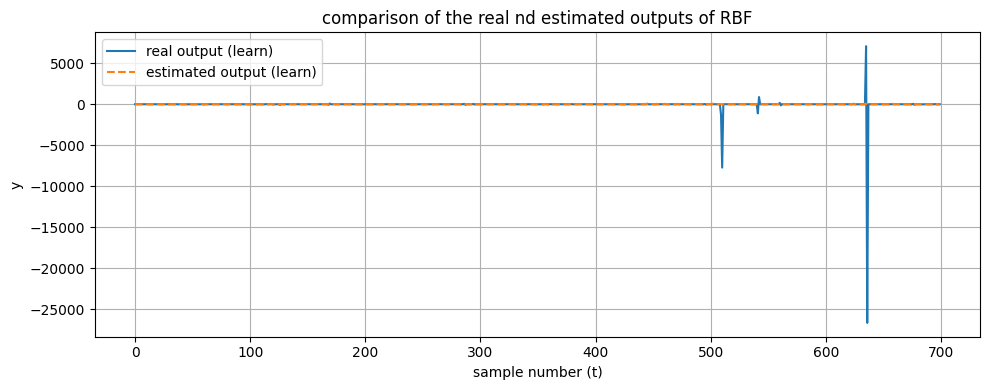

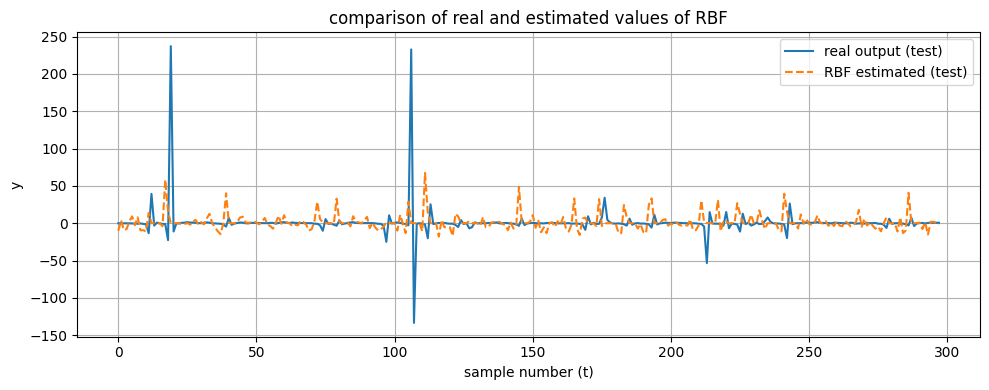

In [18]:
# تنظیم پارامترهای شبکه
K = 20         # مثلا 20 نرون RBF
sigma = 0.5    # مثلا 0.5 به عنوان پهنای اولیه
random_state = 0

# آموزش شبکه
centers, alpha = train_rbf_lls(X_train, y_train, K, sigma, random_state=random_state)

# پیش‌بینی روی آموزش و تست
y_train_hat = predict_rbf(X_train, centers, alpha, sigma)
y_test_hat  = predict_rbf(X_test,  centers, alpha, sigma)

# محاسبه‌ی RMSE
rmse_train = rmse(y_train, y_train_hat)
rmse_test  = rmse(y_test,  y_test_hat)

print("RMSE Train:", rmse_train)
print("RMSE Test :", rmse_test)

# -----------------------------
# رسم نمودار مقایسه‌ای روی داده‌های آموزش (بخش 1-3-2)
# -----------------------------
plt.figure(figsize=(10, 4))
plt.plot(y_train, label='real output (learn)')
plt.plot(y_train_hat, '--', label='estimated output (learn)')
plt.xlabel('sample number (t)')
plt.ylabel('y')
plt.title('comparison of the real nd estimated outputs of RBF')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# رسم نمودار مقایسه‌ای روی داده‌های تست (بخش 1-3-3)
# -----------------------------
plt.figure(figsize=(10, 4))
plt.plot(y_test, label='real output (test)')
plt.plot(y_test_hat, '--', label='RBF estimated (test)')
plt.xlabel('sample number (t)')
plt.ylabel('y')
plt.title('comparison of real and estimated values of RBF')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

K =  10 | RMSE_train = 1085.0855 | RMSE_test = 21.9536
K =  20 | RMSE_train = 1085.0228 | RMSE_test = 24.5837
K =  50 | RMSE_train = 1083.6282 | RMSE_test = 55.8763
K = 100 | RMSE_train = 1071.7783 | RMSE_test = 200.8351
K = 200 | RMSE_train = 1065.8235 | RMSE_test = 283.8093


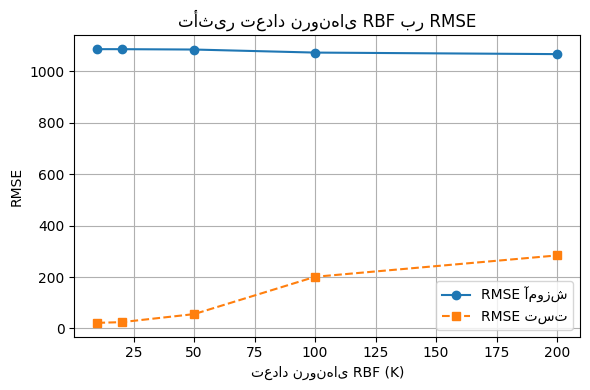

In [19]:
# لیست مقادیر مختلف K
K_list = [10, 20, 50, 100, 200]
sigma_fixed = 0.5   # یک مقدار ثابت برای σ در این آزمایش
random_state = 0

rmse_train_list = []
rmse_test_list = []

for K in K_list:
    centers, alpha = train_rbf_lls(X_train, y_train, K, sigma_fixed, random_state=random_state)
    y_train_hat = predict_rbf(X_train, centers, alpha, sigma_fixed)
    y_test_hat  = predict_rbf(X_test,  centers, alpha, sigma_fixed)

    rmse_tr = rmse(y_train, y_train_hat)
    rmse_te = rmse(y_test,  y_test_hat)

    rmse_train_list.append(rmse_tr)
    rmse_test_list.append(rmse_te)

    print(f"K = {K:3d} | RMSE_train = {rmse_tr:.4f} | RMSE_test = {rmse_te:.4f}")

# رسم نمودار RMSE بر حسب K
plt.figure(figsize=(6,4))
plt.plot(K_list, rmse_train_list, 'o-', label='RMSE آموزش')
plt.plot(K_list, rmse_test_list, 's--', label='RMSE تست')
plt.xlabel('تعداد نرون‌های RBF (K)')
plt.ylabel('RMSE')
plt.title('تأثیر تعداد نرون‌های RBF بر RMSE')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

sigma = 0.10 | RMSE_train = 1085.0886 | RMSE_test = 21.6444
sigma = 0.20 | RMSE_train = 1085.0883 | RMSE_test = 21.6533
sigma = 0.50 | RMSE_train = 1083.6282 | RMSE_test = 55.8763
sigma = 1.00 | RMSE_train = 1081.6611 | RMSE_test = 100.2023
sigma = 2.00 | RMSE_train = 1083.5391 | RMSE_test = 61.7980


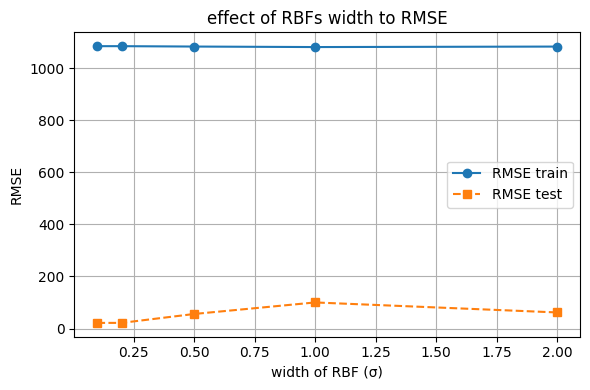

In [20]:
# انتخاب یک K ثابت (مثلا بهترین K از آزمایش قبل)
K_best = 50    # این مقدار را با توجه به نتایج قبلی تنظیم کن

# لیست مقادیر مختلف σ
sigma_list = [0.1, 0.2, 0.5, 1.0, 2.0]

rmse_train_sigma = []
rmse_test_sigma = []

# برای این که فقط اثر σ را ببینیم، مراکز را یکبار برای K_best ثابت انتخاب می‌کنیم
random_state = 0
N_train = X_train.shape[0]
np.random.seed(random_state)
idx = np.random.choice(N_train, size=K_best, replace=False)
centers_fixed = X_train[idx, :]

for sigma in sigma_list:
    # محاسبه‌ی Φ و آموزش وزن‌ها برای این σ
    Phi_train = rbf_gaussian(X_train, centers_fixed, sigma)
    alpha = np.linalg.pinv(Phi_train) @ y_train

    # پیش‌بینی
    y_train_hat = predict_rbf(X_train, centers_fixed, alpha, sigma)
    y_test_hat  = predict_rbf(X_test,  centers_fixed, alpha, sigma)

    rmse_tr = rmse(y_train, y_train_hat)
    rmse_te = rmse(y_test,  y_test_hat)

    rmse_train_sigma.append(rmse_tr)
    rmse_test_sigma.append(rmse_te)

    print(f"sigma = {sigma:.2f} | RMSE_train = {rmse_tr:.4f} | RMSE_test = {rmse_te:.4f}")

# رسم نمودار RMSE بر حسب σ
plt.figure(figsize=(6,4))
plt.plot(sigma_list, rmse_train_sigma, 'o-', label='RMSE train')
plt.plot(sigma_list, rmse_test_sigma, 's--', label='RMSE test')
plt.xlabel('width of RBF (σ)')
plt.ylabel('RMSE')
plt.title('effect of RBFs width to RMSE')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
def train_rbf_ridge(X_train, y_train, K, sigma, lambd, random_state=None):
    """
    آموزش شبکه‌ی RBF ایستا با انتخاب تصادفی مراکز و
    حل مسأله‌ی Ridge Regression (L2 Regularization).

    X_train: (N_train, d) داده‌های ورودی آموزش
    y_train: (N_train,)   خروجی‌های هدف آموزش
    K: تعداد نرون‌های RBF
    sigma: پهنای مشترک
    lambd: λ (پارامتر L2 regularization)
    random_state: برای تکرارپذیری انتخاب مراکز
    خروجی: centers, alpha
    """
    if random_state is not None:
        np.random.seed(random_state)

    N_train, d = X_train.shape

    # انتخاب تصادفی مراکز
    idx = np.random.choice(N_train, size=K, replace=False)
    centers = X_train[idx, :]

    # محاسبه‌ی Φ
    Phi_train = rbf_gaussian(X_train, centers, sigma)  # (N_train, K)

    # حل (Φ^T Φ + λ I) α = Φ^T y
    # ساخت ماتریس A = Φ^T Φ + λ I
    A = Phi_train.T @ Phi_train
    A += lambd * np.eye(K)

    b = Phi_train.T @ y_train

    alpha = np.linalg.solve(A, b)   # حل دستگاه خطی

    return centers, alpha

lambda =  0.000  ->  RMSE_train = 1083.6282,  RMSE_test = 55.8763
lambda =  0.001  ->  RMSE_train = 1083.6557,  RMSE_test = 54.1256
lambda =  0.010  ->  RMSE_train = 1083.7210,  RMSE_test = 52.5975
lambda =  0.100  ->  RMSE_train = 1083.8008,  RMSE_test = 47.1331
lambda =  1.000  ->  RMSE_train = 1084.2099,  RMSE_test = 35.7158
lambda = 10.000  ->  RMSE_train = 1084.7522,  RMSE_test = 26.2709


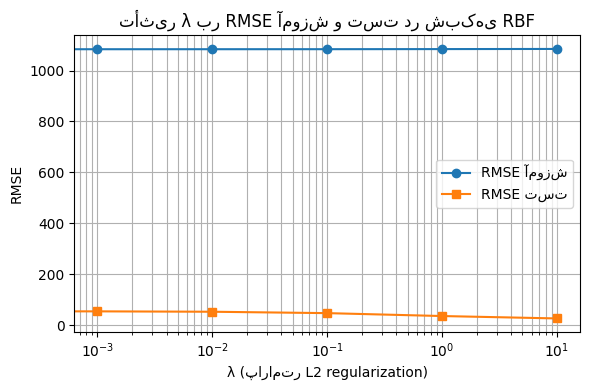

In [22]:
# پارامترهای ثابت شبکه
K = 50        # مثلا یک مقدار نسبتاً بزرگ برای K
sigma = 0.5   # پهنای مشترک
random_state = 0

# مقادیر مختلف λ برای آزمایش
lambda_list = [0.0, 0.001, 0.01, 0.1, 1.0, 10.0]

rmse_train_list = []
rmse_test_list  = []

for lambd in lambda_list:
    centers, alpha = train_rbf_ridge(X_train, y_train, K, sigma, lambd, random_state=random_state)

    # پیش‌بینی
    y_train_hat = predict_rbf(X_train, centers, alpha, sigma)
    y_test_hat  = predict_rbf(X_test,  centers, alpha, sigma)

    # محاسبه‌ی RMSE
    rmse_tr = rmse(y_train, y_train_hat)
    rmse_te = rmse(y_test,  y_test_hat)

    rmse_train_list.append(rmse_tr)
    rmse_test_list.append(rmse_te)

    print(f"lambda = {lambd:6.3f}  ->  RMSE_train = {rmse_tr:.4f},  RMSE_test = {rmse_te:.4f}")

    # رسم نمودار RMSE بر حسب λ (در مقیاس لاگ)
plt.figure(figsize=(6, 4))
plt.semilogx(lambda_list, rmse_train_list, '-o', label='RMSE آموزش')
plt.semilogx(lambda_list, rmse_test_list,  '-s', label='RMSE تست')
plt.xlabel('λ (پارامتر L2 regularization)')
plt.ylabel('RMSE')
plt.title('تأثیر λ بر RMSE آموزش و تست در شبکه‌ی RBF')
plt.grid(True, which='both')
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# فرض: X_train, y_train, X_test, y_test و توابع rbf_gaussian, predict_rbf, rmse
# در دسترس بوده و قبلاً تعریف شده‌اند.

def train_rbf_kmeans(X_train, y_train, K, sigma, random_state=None):
    """
    آموزش شبکه RBF با انتخاب مراکز توسط الگوریتم K-Means.
    """
    # اجرای K-Means روی داده‌های آموزش
    kmeans = KMeans(n_clusters=K, random_state=random_state, n_init=10)
    kmeans.fit(X_train)
    centers = kmeans.cluster_centers_   # مراکز μ_k

    # تشکیل Φ_train و حل LLS
    Phi_train = rbf_gaussian(X_train, centers, sigma)
    alpha = np.linalg.pinv(Phi_train) @ y_train

    return centers, alpha

# مثال استفاده:
K = 10          # تعداد نرون‌ها (طبق ساختار مدنظر)
sigma = 0.5     # پهنای مشترک
random_state = 0

centers_km, alpha_km = train_rbf_kmeans(X_train, y_train, K, sigma, random_state)

# پیش‌بینی روی آموزش و تست
y_train_hat_km = predict_rbf(X_train, centers_km, alpha_km, sigma)
y_test_hat_km  = predict_rbf(X_test,  centers_km, alpha_km, sigma)

# محاسبه‌ی RMSE
rmse_train_km = rmse(y_train, y_train_hat_km)
rmse_test_km  = rmse(y_test,  y_test_hat_km)

print("K-Means centers -> RMSE Train:", rmse_train_km)
print("K-Means centers -> RMSE Test :", rmse_test_km)

# در صورت نیاز، می‌توان نمودار خروجی واقعی / پیش‌بینی‌شده را نیز مانند قبل رسم کرد.

K-Means centers -> RMSE Train: 402.72423052053153
K-Means centers -> RMSE Test : 21.64474537884323


In [24]:
def rbf_gaussian_var_sigma(X, centers, sigmas):
    """
    محاسبه‌ی ماتریس Φ برای RBF گاوسی با σ_k متفاوت برای هر نرون.
    X:      (N, d)
    centers:(K, d)
    sigmas: (K,)  عرض هر نرون
    خروجی: Φ با ابعاد (N, K)
    """
    X = np.asarray(X)
    centers = np.asarray(centers)
    sigmas = np.asarray(sigmas)
    N, d = X.shape
    K, _ = centers.shape
    Phi = np.zeros((N, K))

    for k in range(K):
        diff = X - centers[k]
        dist_sq = np.sum(diff**2, axis=1)
        sigma2 = sigmas[k] ** 2
        Phi[:, k] = np.exp(-dist_sq / (2.0 * sigma2))
    return Phi

In [25]:
def compute_sigmas_nearest_neighbor(centers, p=2.0):
    """
    محاسبه‌ی σ_k برای هر مرکز μ_k بر اساس فاصله تا نزدیک‌ترین مرکز همسایه.
    σ_k = d_k / p
    """
    centers = np.asarray(centers)
    K, d = centers.shape
    sigmas = np.zeros(K)

    for k in range(K):
        # فاصله‌ی μ_k تا سایر مراکز
        diff = centers - centers[k]
        dist = np.linalg.norm(diff, axis=1)
        dist[k] = np.inf  # خود مرکز را حذف می‌کنیم
        d_k = np.min(dist)
        sigmas[k] = d_k / p
    return sigmas

def train_rbf_nn_sigma(X_train, y_train, centers, p=2.0):
    """
    آموزش RBF با مراکز داده‌شده و σ_k مبتنی بر Nearest-Neighbor.
    """
    sigmas = compute_sigmas_nearest_neighbor(centers, p=p)
    Phi_train = rbf_gaussian_var_sigma(X_train, centers, sigmas)
    alpha = np.linalg.pinv(Phi_train) @ y_train
    return sigmas, alpha

In [26]:
# فرض: centers_km از K-Means به دست آمده است
p = 2.0

sigmas_nn, alpha_nn = train_rbf_nn_sigma(X_train, y_train, centers_km, p=p)

# پیش‌بینی روی آموزش و تست
Phi_train_nn = rbf_gaussian_var_sigma(X_train, centers_km, sigmas_nn)
Phi_test_nn  = rbf_gaussian_var_sigma(X_test,  centers_km, sigmas_nn)

y_train_hat_nn = Phi_train_nn @ alpha_nn
y_test_hat_nn  = Phi_test_nn  @ alpha_nn

rmse_train_nn = rmse(y_train, y_train_hat_nn)
rmse_test_nn  = rmse(y_test,  y_test_hat_nn)

print("Nearest-Neighbor sigmas -> RMSE Train:", rmse_train_nn)
print("Nearest-Neighbor sigmas -> RMSE Test :", rmse_test_nn)

Nearest-Neighbor sigmas -> RMSE Train: 402.94462969246536
Nearest-Neighbor sigmas -> RMSE Test : 154.61486675181814
